## Image classification using Food-101 dataset

### Task description
1. Grab the dataset from https://huggingface.co/datasets/food101
2. Implement a convolutional neural network for multiclass image classification.
3. Use https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html or `dl_lab5` for inspiration.

In [6]:
!pip install datasets
!pip install transformers

In [159]:
import torch
import random
import os
import time
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from datasets import load_dataset

In [135]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [70]:
dataset = load_dataset("food101")
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 75750
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 25250
    })
})

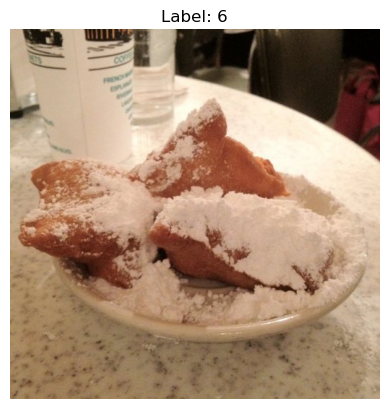

In [71]:
example = dataset['train'][535]

image = example['image']
label = example['label']

plt.imshow(example['image'])
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()

In [136]:
a = 0.001
batch = 16

In [140]:
dataset = load_dataset("food101", split="train[:5%]")
valset = load_dataset("food101", split="validation[:5%]")

In [164]:
class Food101Subset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        label = self.dataset[idx]['label']
        if self.transform:
            image = self.transform(image)
        return image, label

In [165]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

In [166]:
train_subset = Food101Subset(dataset, transform=transform)
val_subset = Food101Subset(valset, transform=transform)

In [167]:
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch, shuffle=False)

In [176]:
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Для автоматичного визначення розмірів після усіх пулінгів
        self.flatten = torch.nn.Flatten()
        self._to_linear = None
        self.convs(torch.randn(3, 150, 150).unsqueeze(0))
        
        self.fc1 = torch.nn.Linear(self._to_linear, 512)
        self.fc2 = torch.nn.Linear(512, 101)
        self.dropout = torch.nn.Dropout(0.5)
        
    def convs(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        x = self.pool(torch.nn.functional.relu(self.conv3(x)))
        if self._to_linear is None:
            self._to_linear = x[0].numel()
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return torch.nn.functional.softmax(x, dim=1)

In [177]:
model = SimpleCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=a)

In [178]:
def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct_predictions = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct_predictions / len(train_loader.dataset)
        print(f"Epoch {epoch+1}, Loss: {epoch_loss}, Accuracy: {epoch_accuracy}")

In [179]:
def evaluate_model(model, val_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = total_loss / len(val_loader)
    accuracy = correct_predictions / len(val_loader.dataset)
    return avg_loss, accuracy

In [180]:
train_model(model, train_loader, criterion, optimizer, epochs=10)
val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

Epoch 1, Loss: 4.436201910429363, Accuracy: 0.19614572333685323
Epoch 2, Loss: 4.434116765919617, Accuracy: 0.1979936642027455
Epoch 3, Loss: 4.433940957870162, Accuracy: 0.1979936642027455
Epoch 4, Loss: 4.434028860888904, Accuracy: 0.1979936642027455
Epoch 5, Loss: 4.434028860888904, Accuracy: 0.1979936642027455
Epoch 6, Loss: 4.434116765919617, Accuracy: 0.1979936642027455
Epoch 7, Loss: 4.433940957870162, Accuracy: 0.1979936642027455
Epoch 8, Loss: 4.433940957870162, Accuracy: 0.1979936642027455
Epoch 9, Loss: 4.434116765919617, Accuracy: 0.1979936642027455
Epoch 10, Loss: 4.433853052839448, Accuracy: 0.1979936642027455
Validation Loss: 4.434204668938359, Validation Accuracy: 0.19809825673534073


In [182]:
os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), os.path.join("models", "food101_cnn.pth"))

тепер детально опиши кожну функцію коду, та всі дії що ми робили. Поясни, що де означає та як працює